<a href="https://colab.research.google.com/github/ysk-cu/MECE4305_LEO_to_MARS/blob/main/FFSC_cycle_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q mermaid-py

In [2]:
!pip install cantera CoolProp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 9.0 MB/s eta 0:00:00


In [3]:
!pip install --no-deps git+https://github.com/davetew/Modern-Aerospace-Propulsion.git
!pip install CoolProp cantera mermaid

  Cloning https://github.com/davetew/Modern-Aerospace-Propulsion.git to /tmp/pip-req-build-d447gnux
  Running command git clone --filter=blob:none --quiet https://github.com/davetew/Modern-Aerospace-Propulsion.git /tmp/pip-req-build-d447gnux
  Resolved https://github.com/davetew/Modern-Aerospace-Propulsion.git to commit 179f6b4008c4c8c2c5e19aa1d690d66cc17992f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for modern-aerospace-propulsion: filename=modern_aerospace_propulsion-0.1.0-py3-none-any.whl size=32474 sha256=b433216bee31e4893789adb936ebc032c0e6dba30b5b918e85192116fc7d6a6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vo2mdd9/wheels/77/00/ae/c5ef1a293a96c094d18bf58431724d9643772d534737428aa6
Successfully built modern-aerospace-propulsion
Requested mermaid from https://files.pythonhosted.org/packages/a7/c4/d259de417b44785e37107399e21c4868244c9baae127346a70119ca5a3a9/mermaid

Total mass flow: 769.97 kg/s
Coolant mass flow: 152.39 kg/s

Max wall temperature: 2079.1 K
Min coolant pressure: 37.85 MPa
Max coolant temperature: 270.4 K


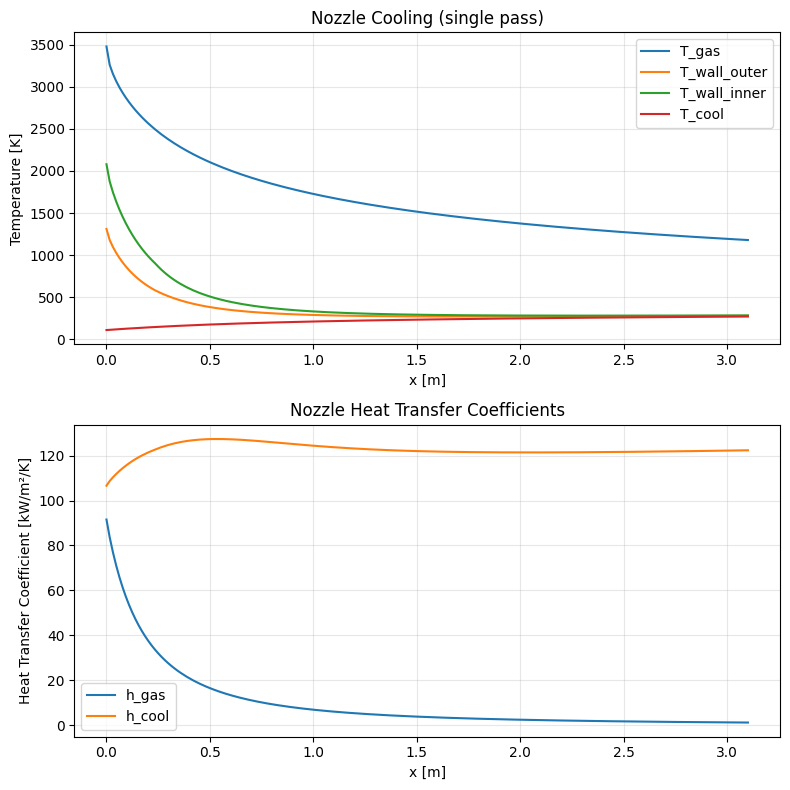


=== FFSC Cycle Summary ===

Performance:
  F_vac                : 2530.1 kN
  Isp_vac_eff          : 335.1 s
  Isp_vac_ideal        : 352.7 s
  Efficiency           : 95.0%

Mass Flows:
  m_dot_total          : 769.97 kg/s
  m_dot_fuel           : 160.41 kg/s
  m_dot_ox             : 609.56 kg/s
  m_dot_cool           : 152.39 kg/s
  Coolant fraction     : 95.0%

Chamber State:
  T0                   : 3814 K
  p0                   : 30.0 MPa
  gamma                : 1.190
  O/F ratio            : 3.80

Cooling:
  T_wall_max           : 2416 K
  dp_cool              : 1.86 MPa

Pressure Rises:
  dp_fuel              : 36.76 MPa
  dp_ox                : 34.90 MPa

Pump Power Required:
  P_pump_fuel          : 18.510 MW
  P_pump_ox            : 24.835 MW
  P_turb_req_fuel      : 18.888 MW
  P_turb_req_ox        : 25.342 MW

Preburner Temperatures:
  T_pb_fuel            : 3715 K
  T_pb_ox              : 3624 K

Turbine Power Available:
  P_turb_avail_fuel    : 873.447 MW
  P_turb_avail_

Mach en sortie de nozzle : 4.85


In [7]:
# Import the required python packages
import numpy as np
import matplotlib.pyplot as plt


from mermaid import Mermaid
import os, subprocess, shutil
from IPython.display import Image, SVG, display

from modern_aerospace_propulsion.ffsc_nozzle import thermo, regen, cycle, sweep
from modern_aerospace_propulsion.ffsc_nozzle.cycle import optimize_ffsc_design

from CoolProp.CoolProp import PropsSI



# Run a nozzle cooling test case with more realistic parameters
r_t = 0.1114                   # Raptor-like throat radius
eps = 106.6
L_noz = 3.1                  # Longer nozzle (Raptor-class)

x, r, A, At = regen.simple_conical_nozzle(r_t, eps, L_noz, N=200)


# === Engine input parameters ===
OF = 3.8            # Oxidizer-to-fuel ratio, typical for CH4/O2 FFSC
p0 = 30e6           # Chamber pressure (Pa), 25 MPa

# Calculate the chamber state with Cantera
T0, gamma, R_g, _ = thermo.cantera_chamber_state(OF=OF, p0=p0)


# Mass flows for demonstration
F_vac = 2530115.7                    # ~258tf vacuum (Raptor-class thrust)
Isp_vac_ideal, _, T_e, M_e = sweep.ideal_vacuum_isp_from_eps(p0, T0, gamma, R_g, eps)
# Isp_vac_ideal = 380
Isp_eff = 0.95*Isp_vac_ideal
g0 = 9.80665
m_dot_total = F_vac/(Isp_eff*g0)
m_dot_fuel = m_dot_total/(1+OF)
m_dot_cool = 0.95*m_dot_fuel   # Use more coolant (50% of fuel flow)

print(f"Total mass flow: {m_dot_total:.2f} kg/s")
print(f"Coolant mass flow: {m_dot_cool:.2f} kg/s")

res_noz = regen.regen_nozzle_1D(
    x=x, r=r, A=A, At=At,
    p0=p0, T0=T0, gamma=gamma, R_g=R_g,
    coolant="Methane",
    coolant_props=regen.make_coolprop_liquid("Methane"),
    m_dot_cool=m_dot_cool,
    n_channels=300,            # More channels
    w_channel=0.003,           # Wider channels
    h_channel=0.008,           # Taller channels
    wall_thickness=0.0015,     # Thinner wall for better heat transfer
    roughness=1e-6,
    T_cool_in=110.0,
    p_cool_in=45e6,            # Higher inlet pressure (45 MPa)
    L_regen=L_noz,             # Cool entire nozzle
)

print(f"\nMax wall temperature: {res_noz['T_wall_inner'].max():.1f} K")
print(f"Min coolant pressure: {res_noz['p_cool'].min()/1e6:.2f} MPa")
print(f"Max coolant temperature: {res_noz['T_cool'].max():.1f} K")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Left subplot: Temperature profiles
ax1.plot(res_noz["x"], res_noz["T_g"], label="T_gas")
ax1.plot(res_noz["x"], res_noz["T_wall_outer"], label="T_wall_outer")
ax1.plot(res_noz["x"], res_noz["T_wall_inner"], label="T_wall_inner")
ax1.plot(res_noz["x"], res_noz["T_cool"], label="T_cool")
ax1.set_xlabel("x [m]")
ax1.set_ylabel("Temperature [K]")
ax1.legend()
ax1.set_title("Nozzle Cooling (single pass)")
ax1.grid(alpha=0.3)

# Right subplot: Heat transfer coefficients
ax2.plot(res_noz["x"], res_noz["h_gas"]/1000, label="h_gas")
ax2.plot(res_noz["x"], res_noz["h_cool"]/1000, label="h_cool")
ax2.set_xlabel("x [m]")
ax2.set_ylabel("Heat Transfer Coefficient [kW/m²/K]")
ax2.legend()
ax2.set_title("Nozzle Heat Transfer Coefficients")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Run full FFSC cycle analysis with adjusted parameters for feasibility
summary = cycle.ffsc_full_flow_cycle(
    F_vac=F_vac,
    p0=p0,
    OF=OF,
    r_t=r_t,
    eps=eps,
    L_noz=L_noz,
    # Propellant specification
    fuel_name="CH4",               # Cantera species name
    ox_name="O2",                  # Cantera species name
    fuel_coolprop="Methane",       # CoolProp fluid name
    ox_coolprop="Oxygen",          # CoolProp fluid name
    T_fuel_tank=110.0,             # Fuel tank temperature (K)
    T_ox_tank=90.0,                # Oxidizer tank temperature (K)
    # Cooling parameters from our nozzle test
    n_channels=300,
    w_channel=0.03,
    wall_thickness=0.0015,
    p_cool_in=45e6,
    # Cycle parameters adjusted for feasibility
    T_turb_out=1000.0,         # Turbine exit temp much lower than preburner temp
    coolant_fraction_override=0.95,  # Use 95% of fuel flow for cooling
    eta_pump_fuel=0.75,        # Slightly higher pump efficiency
    eta_pump_ox=0.75,
    eta_turb_fuel=0.92,        # Slightly higher turbine efficiency
    eta_turb_ox=0.92,
    injector_dp_frac=0.15,     # Reduced from 0.2 - lower injector pressure drop
    feed_line_dp=0.5e6,        # Reduced from 1.0 MPa - lower feed line losses
)

print("\n=== FFSC Cycle Summary ===\n")

# Organize output by category
print("Performance:")
print(f"  F_vac                : {summary['F_vac']/1e3:.1f} kN")
print(f"  Isp_vac_eff          : {summary['Isp_vac_eff']:.1f} s")
print(f"  Isp_vac_ideal        : {summary['Isp_vac_ideal']:.1f} s")
print(f"  Efficiency           : {summary['Isp_vac_eff']/summary['Isp_vac_ideal']*100:.1f}%")

print("\nMass Flows:")
print(f"  m_dot_total          : {summary['m_dot_total']:.2f} kg/s")
print(f"  m_dot_fuel           : {summary['m_dot_fuel']:.2f} kg/s")
print(f"  m_dot_ox             : {summary['m_dot_ox']:.2f} kg/s")
print(f"  m_dot_cool           : {summary['m_dot_cool']:.2f} kg/s")
print(f"  Coolant fraction     : {summary['coolant_fraction']:.1%}")

print("\nChamber State:")
print(f"  T0                   : {summary['T0']:.0f} K")
print(f"  p0                   : {p0/1e6:.1f} MPa")
print(f"  gamma                : {summary['gamma']:.3f}")
print(f"  O/F ratio            : {OF:.2f}")

print("\nCooling:")
print(f"  T_wall_max           : {summary['T_wall_max']:.0f} K")
print(f"  dp_cool              : {summary['dp_cool']/1e6:.2f} MPa")

print("\nPressure Rises:")
print(f"  dp_fuel              : {summary['dp_fuel']/1e6:.2f} MPa")
print(f"  dp_ox                : {summary['dp_ox']/1e6:.2f} MPa")

print("\nPump Power Required:")
print(f"  P_pump_fuel          : {summary['P_pump_fuel']/1e6:.3f} MW")
print(f"  P_pump_ox            : {summary['P_pump_ox']/1e6:.3f} MW")
print(f"  P_turb_req_fuel      : {summary['P_turb_req_fuel']/1e6:.3f} MW")
print(f"  P_turb_req_ox        : {summary['P_turb_req_ox']/1e6:.3f} MW")

print("\nPreburner Temperatures:")
print(f"  T_pb_fuel            : {summary['T_pb_fuel']:.0f} K")
print(f"  T_pb_ox              : {summary['T_pb_ox']:.0f} K")

print("\nTurbine Power Available:")
print(f"  P_turb_avail_fuel    : {summary['P_turb_avail_fuel']/1e6:.3f} MW")
print(f"  P_turb_avail_ox      : {summary['P_turb_avail_ox']/1e6:.3f} MW")

print("\nFeasibility:")
fuel_margin = (summary['P_turb_avail_fuel'] - summary['P_turb_req_fuel'])/summary['P_turb_req_fuel']*100
ox_margin = (summary['P_turb_avail_ox'] - summary['P_turb_req_ox'])/summary['P_turb_req_ox']*100
print(f"  Fuel side margin     : {fuel_margin:+.1f}%")
print(f"  Ox side margin       : {ox_margin:+.1f}%")
print(f"  fuel_side_ok         : {bool(summary['fuel_side_ok'])}")
print(f"  ox_side_ok           : {bool(summary['ox_side_ok'])}")

if summary['fuel_side_ok'] and summary['ox_side_ok']:
    print("\n✓ FFSC cycle is FEASIBLE - both turbopump sides can be balanced!")
else:
    print("\n✗ FFSC cycle is NOT feasible - turbines cannot provide sufficient power")

import os, subprocess, shutil
from IPython.display import Image, SVG, display
from mermaid import Mermaid # Make sure Mermaid is imported

# Dynamically generate Mermaid diagram from FFSC cycle results
use_svg = True
mmd_path = "ffsc_schematic.mmd"
out_svg = "ffsc_schematic.svg"
out_png = "ffsc_schematic.png"

# Extract key values from summary
m_dot_fuel_val = summary['m_dot_fuel']
m_dot_ox_val = summary['m_dot_ox']
m_dot_cool_val = summary['m_dot_cool']
dp_fuel_val = summary['dp_fuel'] / 1e6  # MPa
dp_ox_val = summary['dp_ox'] / 1e6  # MPa
dp_cool_val = summary['dp_cool'] / 1e6  # MPa
T_pb_fuel_val = summary['T_pb_fuel']
T_pb_ox_val = summary['T_pb_ox']
T_wall_max_val = summary['T_wall_max']
T_turb_exit = 1000.0  # From our T_turb_out parameter
dT_fuel_turb = T_pb_fuel_val - T_turb_exit
dT_ox_turb = T_pb_ox_val - T_turb_exit
T_cool_out = summary['nozzle_results']['T_cool'][-1]  # Exit coolant temp
dT_cool = T_cool_out - 110.0
T0_val = summary['T0']
p0_val = p0 / 1e6  # MPa
p_cool_in_val = 30.0  # MPa (from cycle analysis parameters)
eps_val = eps
Isp_val = summary['Isp_vac_eff']
F_vac_val = summary['F_vac'] / 1e3  # kN
OF_val = OF

# Calculate equivalence ratios (phi) for preburners
phi_fuel_pb = 1.3  # Fuel-rich
phi_ox_pb = 0.7  # Ox-rich

# Estimate preburner flows (small fractions for preburners)
# FFSC: all propellant goes through preburners, but we can estimate split
m_dot_fuel_to_cool = m_dot_cool_val
m_dot_fuel_to_pb = m_dot_fuel_val - m_dot_fuel_to_cool

# For fuel-rich preburner: mostly fuel, small amount of ox
# Stoichiometric O/F for CH4/O2 is ~4.0, so phi=1.3 means excess fuel
# O/F_pb_fuel = 4.0/1.3 ≈ 3.08
OF_pb_fuel = 4.0 / phi_fuel_pb
m_dot_ox_to_fuel_pb = m_dot_fuel_to_pb * OF_pb_fuel / (1 + OF_pb_fuel)
m_dot_fuel_to_fuel_pb = m_dot_fuel_to_pb / (1 + OF_pb_fuel)

# For ox-rich preburner: mostly ox, small amount of fuel
# phi=0.7 means excess oxidizer
# O/F_pb_ox = 4.0/0.7 ≈ 5.71
OF_pb_ox = 4.0 / phi_ox_pb
m_dot_ox_to_ox_pb = m_dot_ox_val - m_dot_ox_to_fuel_pb
m_dot_fuel_to_ox_pb = m_dot_ox_to_ox_pb / OF_pb_ox

# Remaining oxidizer goes to chamber
m_dot_ox_to_chamber = m_dot_ox_val - m_dot_ox_to_fuel_pb - m_dot_ox_to_ox_pb

# Pressures after pumps
p_fuel_pump_out = p0_val + dp_fuel_val
p_ox_pump_out = p0_val + dp_ox_val
p_cool_out = p_cool_in_val - dp_cool_val

mermaid_code = f"""%%{{init: {{'theme':'default','themeVariables': {{'lineColor':'#333333','primaryTextColor':'#000000'}}}}}}%%
graph LR
    %% Fuel side (top row)
    LCH4[LCH4 Tank<br/>T = 110 K<br/>ṁ = {m_dot_fuel_val:.1f} kg/s]
    FuelPump[Fuel Pump<br/>ΔP = {dp_fuel_val:.1f} MPa<br/>p_out = {p_fuel_pump_out:.1f} MPa]
    FuelPB[Fuel-Rich<br/>Preburner<br/>φ = {phi_fuel_pb:.1f}<br/>T = {T_pb_fuel_val:.0f} K<br/>p = {p0_val:.0f} MPa]
    FuelTurb[Fuel Turbine<br/>T_in = {T_pb_fuel_val:.0f} K<br/>T_out = {T_turb_exit:.0f} K]

    %% Oxidizer side (bottom row)
    LOX[LOX Tank<br/>T = 90 K<br/>ṁ = {m_dot_ox_val:.1f} kg/s]
    OxPump[Oxidizer Pump<br/>ΔP = {dp_ox_val:.1f} MPa<br/>p_out = {p_ox_pump_out:.1f} MPa]
    OxPB[Ox-Rich<br/>Preburner<br/>φ = {phi_ox_pb:.1f}<br/>T = {T_pb_ox_val:.0f} K<br/>p = {p0_val:.0f} MPa]
    OxTurb[Oxidizer Turbine<br/>T_in = {T_pb_ox_val:.0f} K<br/>T_out = {T_turb_exit:.0f} K]

    %% Cooling system
    Jacket[Regenerative<br/>Cooling Jacket<br/>ΔP = {dp_cool_val:.1f} MPa<br/>T_out = {T_cool_out:.0f} K]

    %% Combustion chamber
    Chamber[Main Chamber<br/>O/F = {OF_val:.1f}<br/>T₀ = {T0_val:.0f} K<br/>p₀ = {p0_val:.0f} MPa]
    Nozzle[Nozzle<br/>ε = {eps_val:.0f}<br/>Isp = {Isp_val:.0f} s]
    Thrust[Thrust<br/>{F_vac_val:.0f} kN]

    %% Fuel flow paths (red/orange for fuel)
    LCH4 -->|{m_dot_fuel_val:.1f} kg/s<br/>110 K| FuelPump
    FuelPump -->|{m_dot_cool_val:.1f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| Jacket
    FuelPump -->|{m_dot_fuel_to_fuel_pb:.1f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| FuelPB
    Jacket -->|{m_dot_cool_val:.1f} kg/s<br/>{T_cool_out:.0f} K<br/>{p_cool_out:.1f} MPa| Chamber

    %% Oxidizer to fuel preburner (purple for cross-connections)
    OxPump -.->|{m_dot_ox_to_fuel_pb:.2f} kg/s<br/>{p_ox_pump_out:.1f} MPa| FuelPB
    FuelPB -->|{m_dot_fuel_to_fuel_pb + m_dot_ox_to_fuel_pb:.1f} kg/s<br/>{T_pb_fuel_val:.0f} K| FuelTurb
    FuelTurb -->|{m_dot_fuel_to_fuel_pb + m_dot_ox_to_fuel_pb:.1f} kg/s<br/>{T_turb_exit:.0f} K| Chamber

    %% Oxidizer flow paths (blue for oxidizer)
    LOX -->|{m_dot_ox_val:.1f} kg/s<br/>90 K| OxPump
    OxPump -->|{m_dot_ox_to_ox_pb:.1f} kg/s<br/>{p_ox_pump_out:.1f} MPa| OxPB
    OxPump -->|{m_dot_ox_to_chamber:.1f} kg/s<br/>{p_ox_pump_out:.1f} MPa| Chamber

    %% Fuel to ox preburner (purple for cross-connections)
    FuelPump -.->|{m_dot_fuel_to_ox_pb:.2f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| OxPB
    OxPB -->|{m_dot_ox_to_ox_pb + m_dot_fuel_to_ox_pb:.1f} kg/s<br/>{T_pb_ox_val:.0f} K| OxTurb
    OxTurb -->|{m_dot_ox_to_ox_pb + m_dot_fuel_to_ox_pb:.1f} kg/s<br/>{T_turb_exit:.0f} K| Chamber

    %% Power transmission (mechanical coupling - green dashed)
    FuelTurb -.->|Shaft Power<br/>{summary['P_turb_avail_fuel']/1e6:.2f} MW| FuelPump
    OxTurb -.->|Shaft Power<br/>{summary['P_turb_avail_ox']/1e6:.2f} MW| OxPump

    %% Exhaust (hot gas - yellow/orange)
    Chamber --> Nozzle
    Nozzle --> Thrust

    %% Styling for white background
    classDef fuel fill:#ffcccc,stroke:#cc0000,stroke-width:3px,color:#000000
    classDef ox fill:#cce5ff,stroke:#0066cc,stroke-width:3px,color:#000000
    classDef hot fill:#ffe6cc,stroke:#ff6600,stroke-width:3px,color:#000000
    classDef chamber fill:#fff4cc,stroke:#cc9900,stroke-width:4px,color:#000000
    class LCH4,FuelPump,FuelPB,FuelTurb,Jacket fuel
    class LOX,OxPump,OxPB,OxTurb ox
    class Chamber,Nozzle chamber

    %% Link colors for visibility on white background
    linkStyle 0,1,2,3,5,6 stroke:#cc0000,stroke-width:3px
    linkStyle 7,8,9,11,12 stroke:#0066cc,stroke-width:3px
    linkStyle 4,10 stroke:#9900cc,stroke-width:2px
    linkStyle 13,14 stroke:#009900,stroke-width:2px
    linkStyle 15,16 stroke:#ff6600,stroke-width:3px
"""

# Write the Mermaid source
with open(mmd_path, "w") as f:
    f.write(mermaid_code)

# Ensure mermaid-cli (mmdc) is available (not strictly needed for display here, but good for export)
mmdc = shutil.which("mmdc")
if mmdc is None:
    print("Warning: Mermaid CLI 'mmdc' not found. File export (SVG/PNG) may fail. Install with: npm install -g @mermaid-js/mermaid-cli")

# Display the Mermaid diagram directly in the notebook
display(Mermaid(mermaid_code))

print(f"Mach en sortie de nozzle : {M_e:.2f}")
